# Automatic dijk-profile annotation
Train & annotation code. If you just want to annotate a new batch of profiles, run the imports and network architecture below and jump to the [Inference Section](#inference_cell). <br>
- For Training a new network and preprocessing new files, follow the instructions from the [start](#import_cell) of the notebook. 
- If all files are already preprocessed (there are pickles in the pickles/ folder, run the everything up until the training section and continue by loading the pickles [here](#load_pickles_cell)

Requirements for the conda environment used to run this notebook can be found in the `requirements.txt` file.

```
#-------------------------------------------------------------------------------
# Name:        dijkprofile_annotation
# Purpose:     Annotation of dijkprofiles & training of new annotation network
#
# Author:      jgerbscheid
#
# Created:     19-09-2019
# Copyright:   (c) jgerbscheid 2019
# Licence:     MIT
#-------------------------------------------------------------------------------```

# Imports & functions

In [1]:
# imports
from __future__ import print_function, division
import numpy as np
# import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import torch.nn.functional as F
import csv
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm
from tqdm import tqdm_notebook
import time
import pickle
from sklearn.preprocessing import StandardScaler
import os
import torch
import pandas as pd
import glob
import joblib
import seaborn as sns
import datetime 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from operator import itemgetter
from torch.autograd import Variable
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# setup folders.
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("pickles", exist_ok=True)

/data/anaconda3/envs/pytorch/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Network architecture
Construct the network


In [2]:
class Double_conv(nn.Module):
    '''(conv => ReLU) * 2 => MaxPool2d'''
    def __init__(self, in_ch, out_ch, p):
        """
        Args:
            in_ch(int) : input channel
            out_ch(int) : output channel
        """
        super(Double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 5, padding=2, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 7, padding=3, stride=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=p)
        )
    def forward(self, x):
        x = self.conv(x)
        return x


class Conv_down(nn.Module):
    '''(conv => ReLU) * 2 => MaxPool2d'''
    
    def __init__(self, in_ch, out_ch, p):
        """
        Args:
            in_ch(int) : input channel
            out_ch(int) : output channel
        """
        super(Conv_down, self).__init__()
        self.conv = Double_conv(in_ch, out_ch, p)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.conv(x)
        pool_x = self.pool(x)
        return pool_x, x


class Conv_up(nn.Module):
    '''(conv => ReLU) * 2 => MaxPool2d'''
    
    def __init__(self, in_ch, out_ch, p):
        """
        Args:
            in_ch(int) : input channel
            out_ch(int) : output channel
        """
        super(Conv_up, self).__init__()
        self.up = nn.ConvTranspose1d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = Double_conv(in_ch, out_ch, p)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1_dim = x1.size()[2]
        x2 = extract_img(x1_dim, x2)
        x1 = torch.cat((x1, x2), dim=1)
        x1 = self.conv(x1)
        return x1


def extract_img(size, in_tensor):
    """
    Args:
        size(int) : size of cut
        in_tensor(tensor) : tensor to be cut
    """
    dim1 = in_tensor.size()[2]
    in_tensor = in_tensor[:, :, int((dim1-size)/2):int((size + (dim1-size)/2))]
    return in_tensor


class Dijknet(nn.Module):
    def __init__(self, in_channels, out_channels, p=0.25):
        super(Dijknet, self).__init__()
        self.Conv_down1 = Conv_down(in_channels, 64, p)
        self.Conv_down2 = Conv_down(64, 128, p)
        self.Conv_down3 = Conv_down(128, 256, p)
        self.Conv_down4 = Conv_down(256, 512, p)
        self.Conv_down5 = Conv_down(512, 1024, p)
        self.Conv_up1 = Conv_up(1024, 512, p)
        self.Conv_up2 = Conv_up(512, 256, p)
        self.Conv_up3 = Conv_up(256, 128, p)
        self.Conv_up4 = Conv_up(128, 64, p)
        self.Conv_up5 = Conv_up(128, 64, p)
        self.Conv_out = nn.Conv1d(64, out_channels, 1, padding=0, stride=1)
        self.Conv_final = nn.Conv1d(out_channels, out_channels, 1, padding=0, stride=1)

    def forward(self, x):
        input_image = x
        x, conv1 = self.Conv_down1(x)
        x, conv2 = self.Conv_down2(x)
        x, conv3 = self.Conv_down3(x)
        x, conv4 = self.Conv_down4(x)
        _, x = self.Conv_down5(x)
        x = self.Conv_up1(x, conv4)
        x = self.Conv_up2(x, conv3)
        x = self.Conv_up3(x, conv2)
        x = self.Conv_up4(x, conv1)
        # final upscale to true size
        x = self.Conv_out(x)
        x = self.Conv_final(x)
        return x

print("done!")

done!


### Conversion dicts for the csv inpute files, maps names to classnumbers
Construct various dicts to convert the original data to a usable format

In [3]:
ben_conversion_dict = {
    "": "leeg",
    "101_Q19_2" : "buitenkruin",
    "101_Q19_3" : "binnenkruin",
    "101_Q19_5" : "binnenteen",
    "105_T09_11": "insteek_sloot",
    "811_T13_8" : "leeg",
    "351_T03_10" : "leeg",
    "_T01_KKW" : "leeg",
    "108_Q06_250" : "leeg",
    "303_Q05_1": "leeg",
    "353__11" : "leeg",
    "_T00_17" : "leeg",
    "109_Q08_13" : "leeg",
    "_Q07_KDM" : "leeg",
    "_Q07_KDW" : "leeg",
    '0' : "leeg",
    None : "leeg",
    'nan' : "leeg"
}
class_dict_regionaal = {
    "leeg": 0,
    "startpunt": 1,
    "buitenkruin": 2,
    "binnenkruin": 3,
    "binnenteen": 4,
    "insteek_sloot": 5
}

class_dict = {
    'leeg': 0,
    'Maaiveld binnenwaarts': 1,
    'Insteek sloot polderzijde': 2,
    'Slootbodem polderzijde': 3,
    'Slootbodem dijkzijde': 4,
    'Insteek sloot dijkzijde': 5,
    'Teen dijk binnenwaarts': 6,
    'Kruin binnenberm': 7,
    'Insteek binnenberm': 8,
    'Kruin binnentalud': 9,
    'Verkeersbelasting kant binnenwaarts': 9, # 10
    'Verkeersbelasting kant buitenwaarts': 10,
    'Kruin buitentalud': 10, #12
    'Insteek buitenberm': 11,
    'Kruin buitenberm': 12,
    'Teen dijk buitenwaarts': 13,
    'Insteek geul': 14,
    'Teen geul': 15,
    'Maaiveld buitenwaarts': 16,
}

# set the class dict to either the full class_dict for non-regional keringen (leave it)
# or set it to the smaller dict for regional keringen by uncommenting this line

# class_dict = class_dict_regionaal
inverse_class_dict = {v: k for k, v in class_dict.items()}

# manual mappings to get the correct names for plotting later
if "11" in inverse_class_dict:
    inverse_class_dict["10"] = 'Kruin buitentalud'


In [4]:
def ffill(arr):
    """Forward fill utility function."""
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

def convert_tool_data(annotation_tuples):
    profile_dict = {}
    surfaceline_dict_total = {}
    for source_surfacelines, source_characteristicpoints in annotation_tuples:
        surfaceline_dict = {}

        # read the coordinates and collect to surfaceline_dict
        with open(source_surfacelines) as csvfile:
            surfacereader = csv.reader(csvfile, delimiter=';', quotechar='|')
            header = next(surfacereader)
            # print("header: {}".format(header)) # not very useful
            for row in surfacereader:
                location = row[0]
                surfaceline_dict[location] = []
                for i in range(1, len(row)-2, 3):
                    try:
                        x = float(row[i])
                        y = float(row[i+1])
                        z = float(row[i+2])
                        surfaceline_dict[location].append((x,y,z))
                    except:
                        print("error reading point from surfaceline at location: ", location)
                        print("index: ", i)
                        pass

        print("loaded surfacelines for {} locations".format(len(surfaceline_dict.keys())))

        cpoints_dict = {}
        # read the characteristicpoints and save to cpoints_dict
        with open(source_characteristicpoints) as csvfile:
            cpointsreader = csv.reader(csvfile, delimiter=';', quotechar='|')
            header = next(cpointsreader)
            for row in cpointsreader:
                location = row[0]
                point_dict = {}
                for i in range(1, len(row)-2, 3):
                    try:
                        x = float(row[i])
                        y = float(row[i+1])
                        z = float(row[i+2])

                        point_dict[header[i][2:]] = (x,y,z)
                    except:
                        pass
                cpoints_dict[location] = point_dict

        print("loaded characteristic points for {} locations".format(len(cpoints_dict.keys())))

        # transform the data to a usable format, save to profile_dict
        X_samples_list = []
        Y_samples_list = []
        location_list = []
        for location in surfaceline_dict.keys():
            heights = np.array(surfaceline_dict[location])[:,2].astype(np.float32)
            x_y_s = np.array(surfaceline_dict[location])[:,:2].astype(np.float32)
            labels = np.zeros(len(heights))
            for i, (key, point) in enumerate(cpoints_dict[location].items()):
                # if the point is not empty, find the nearest point in the surface file, 
                # rounding errors require matching by distance per point
                if point == (-1.0, -1.0, -1.0):
                    continue

                distances = []
                for idx, surfacepoint in enumerate(surfaceline_dict[location]):
                    dist = np.linalg.norm(np.array(surfacepoint)-np.array(point))
                    distances.append((idx, dist))
                (idx, dist) = sorted(distances, key=itemgetter(1))[0]
                labels[idx] = class_dict[key]

            for i in range(1, len(labels)):
                if labels[i] == 0.0:
                    labels[i] = labels[i-1]

            z_tmp = np.zeros(352)
            labels_tmp = np.zeros(352)
            profile_length = labels.shape[0]
            if profile_length < 352:
                z_tmp[:profile_length] = np.array(heights, dtype=np.float32)[:profile_length]
                labels_tmp[:profile_length] = np.array(labels)[:profile_length]
                z_tmp[profile_length:] = heights[profile_length-1]
                labels_tmp[profile_length:] = labels[profile_length-1]
                heights = z_tmp
                labels = labels_tmp
            else:
                heights = heights[:352]
                labels = labels[:352]

            profile_dict[location] = {}
            profile_dict[location]['profile'] = heights.astype(np.float32)
            profile_dict[location]['label'] = labels.astype(np.int32)

        for key, value in surfaceline_dict.items():
            surfaceline_dict_total[key] = value
    
    return profile_dict, surfaceline_dict_total

# Training code
Run this section to process the raw data and train a new annotation network, if you just want to generate annotations for a new set of profiles go to the [Inference Section](#inference_cell)

## Read regular dijk profiles, transform and save to pickle

In [6]:
filename_dijkprofile_dict = 'pickles/dijkprofile_dict.pik'
filename_surfaceline_dict = 'pickles/surfaceline_dict.pik'

# source_surfacelines = 'data/dijkprofiles_fryslan/2-2/surfacelines.csv'
# source_characteristicpoints = 'data/dijkprofiles_fryslan/2-2/characteristicpoints.csv'

# data to use for training
annotation_tuples = [
    ('data/dijkprofiles_fryslan/2-2/surfacelines.csv', 'data/dijkprofiles_fryslan/2-2/characteristicpoints.csv'),
    ('data/dijkprofiles_fryslan/6-3/surfacelines.csv', 'data/dijkprofiles_fryslan/6-3/characteristicpoints.csv'),
    ('data/dijkprofiles_fryslan/6-4/surfacelines.csv', 'data/dijkprofiles_fryslan/6-4/characteristicpoints.csv'),
    ('data/dijkprofielen_13-4_primair/surfacelines.csv', 'data/dijkprofielen_13-4_primair/characteristicpoints.csv'),
    ('data/surfacelines_12-2.csv', 'data/characteristicpoints_12-2.csv')
]

profile_dict, surfaceline_dict_total = convert_tool_data(annotation_tuples)

outfile = open(filename_dijkprofile_dict, 'wb')
pickle.dump(profile_dict, outfile)
outfile.close()
outfile2 = open(filename_surfaceline_dict, 'wb')
pickle.dump(surfaceline_dict_total, outfile2)
outfile2.close()
print("done!")

loaded surfacelines for 166 locations
loaded characteristic points for 166 locations
loaded surfacelines for 371 locations
loaded characteristic points for 371 locations
loaded surfacelines for 580 locations
loaded characteristic points for 580 locations
loaded surfacelines for 454 locations
loaded characteristic points for 454 locations
loaded surfacelines for 822 locations
loaded characteristic points for 822 locations
done!


## Read regional keringen and save to pickle
Read and preprocess the regional kering files. Skip unless you're training a regional keringen network.

In [32]:
def is_df_sorted(df, colname):
    return pd.Index(df[colname]).is_monotonic

def ffill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

reg_keringen_profiles = {}

# profile_names = reg_keringen_ENTRIES['RFLNAAM'].unique()
files = glob.glob("data/ben_regionale_keringen/*.csv")

for filename in files:
    with open(filename) as csvfile:
        cpointsreader = csv.reader(csvfile, delimiter=';', quotechar='|')
        header = next(cpointsreader)
        lastlocation = None
        z = []
        label = []
        for i , row in enumerate(cpointsreader):
            location = row[0]
            if i == 0:
                lastlocation = location

            if location == lastlocation:
                label.append(str(row[4]))
                z.append(float(row[7].replace(',','.')))
            else:
                try:
                    label = [ben_conversion_dict[labelname] for labelname in label]
                    label = [class_dict_regionaal[labelcode] for labelcode in label]
                except:
                    pass
                label[0] = 1
                for i in range(1, len(label)):
                    if label[i] == 0.0:
                        label[i] = label[i-1]
                        
                z_tmp = np.zeros(256)
                labels_tmp = np.zeros(256)
                z_tmp[:150] = np.array(z, dtype=np.float32)[:150]
                labels_tmp[:150] = np.array(label)[:150]
                z_tmp[150:] = z[-1]
                labels_tmp[151:] = label[-1]

                reg_keringen_profiles[lastlocation] = {}
                reg_keringen_profiles[lastlocation]['profile'] = z_tmp.astype(np.float32)
                reg_keringen_profiles[lastlocation]['label'] = labels_tmp.astype(np.int32)
                lastlocation = location
                z = []
                label = []
            
print(len(reg_keringen_profiles))
outfile = open('data/reg_keringen.pik', 'wb')
pickle.dump(reg_keringen_profiles,outfile)
outfile.close()


0


<a id='load_pickles_cell'></a>
## Load profiles from dicts 
Load the preprocessed data from pickled dictionaries. Reads dicts generated and saved in the code above, you can start here if the pickle files are already generated.

In [5]:
profile_dict = pickle.load(open('pickles/dijkprofile_dict.pik', 'rb'))
surfaceline_dict = pickle.load(open('pickles/surfaceline_dict.pik', 'rb'))

if len(profile_dict) != len(surfaceline_dict):
    print('set of characteristic points is not equal to set of surfacelines. Something went wrong!')

print("size of profile_dict: ", len(profile_dict))
print("size of surfaceline_dict: ", len(surfaceline_dict))

size of profile_dict:  2393
size of surfaceline_dict:  2393


## Preprocess data/train scaler
Transforms the profiles into a numpy array to be used for inference and trains scalers, be careful not to run this twice, as the scaled data would be scaled again.

In [6]:
randkey = np.random.choice(list(profile_dict.keys()))

accumulator = np.zeros((len(profile_dict), profile_dict[randkey]['profile'].shape[0]))

for i, key in enumerate(profile_dict.keys()):
    accumulator[i, :] = profile_dict[key]['profile']

scaler = StandardScaler()
scaler.fit(accumulator.reshape(-1, 1))

joblib.dump(scaler, 'pickles/scaler.pik')

for i, key in enumerate(profile_dict.keys()):
    profile_dict[key]['profile'] = scaler.transform(profile_dict[key]['profile'].reshape(-1,1)).reshape(-1)
    
print("scaler params: ", scaler.scale_, scaler.mean_, scaler.var_, scaler.n_samples_seen_)
print("should look something like this for primaire_keringen: [11.34926616] [-3.5894847] [128.80584227] 842336")

scaler params:  [11.34926616] [-3.5894847] [128.80584227] 842336
should look something like this for primaire_keringen: [11.34926616] [-3.5894847] [128.80584227] 842336


## Split dataset
Construct a dataset class for the dijkprofile data and use it to construct the pytorch dataloader class

In [7]:
from torch.utils import data
from sklearn.model_selection import train_test_split

class DijkprofileDataset(data.Dataset):
    """Pytorch custom dataset class to use with the pytorch dataloader."""
    
    def __init__(self, profile_dict, partition):
        'init'
        self.data_dict = profile_dict
        self.list_IDs = partition
    
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        X = self.data_dict[ID]['profile'].reshape(1,-1).astype(np.float32)
        y = self.data_dict[ID]['label'].reshape(1,-1)
        return X, y
    
    def __str__(self):
        return "<Dijkprofile dataset: datapoints={}>".format(len(self.list_IDs))


def get_loss_train(model, data_train, criterion):
    """Calculate loss over train set"""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_acc = 0
    total_loss = 0
    for batch, (images, masks) in enumerate(data_train):
        with torch.no_grad():
            images = Variable(images.to(device))
            masks = Variable(masks.to(device))
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = torch.argmax(outputs, dim=1).float()
            acc = accuracy_check_for_batch(masks.cpu(), preds.cpu(), images.size()[0])
            total_acc = total_acc + acc
            total_loss = total_loss + loss.cpu().item()
    return total_acc/(batch+1), total_loss/(batch + 1)

# construct dataloaders
id_list = list(profile_dict.keys())
[train, test] = train_test_split(id_list, shuffle=True, test_size=0.2)

partition = {'train': train, 'validation': test}
dataset_train = DijkprofileDataset(profile_dict, train)
dataset_validation = DijkprofileDataset(profile_dict, test)
print(dataset_train)
print(dataset_validation)

<Dijkprofile dataset: datapoints=1914>
<Dijkprofile dataset: datapoints=479>


In [ ]:
from torch.utils import data

# CUDA for PyTorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 16}

params_val = {'batch_size': 512,
          'shuffle': True,
          'num_workers': 16}
max_epochs = 100

# Generators
training_generator = data.DataLoader(dataset_train, **params)
validation_generator = data.DataLoader(dataset_validation, **params_val)

# construct network with 1 channel input, and n outputs equal to number of classes to predict
model = Dijknet(1, len(set(class_dict.values())))

model.to(device)
# parallel model does not work, might have something to do with the cpu on this machine.
# model = torch.nn.DataParallel(model, device_ids=list(
#         range(torch.cuda.device_count())))

# loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loop over epochs
for epoch in range(max_epochs):
    print("epoch: {}".format(epoch))
    # Training
    loss_list = []
    model.train()
    for local_batch, local_labels in training_generator:
        # bug with dataloader, it doesn't return the right size batch when it runs out of samples
        if not local_labels.shape[0] == params['batch_size']:
            continue
        
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device).long()

        # Model computations
        outputs = model(local_batch)
        local_labels = local_labels.reshape(params['batch_size'], -1)
        loss = criterion(outputs, local_labels)
        optimizer.zero_grad()
        loss.backward()
        
        # Update weights
        optimizer.step()
        loss_list.append(loss.detach().cpu().numpy())
    
    # report average loss over epoch
    print("training loss: ", np.mean(loss_list))
    
    # Validation
    model.eval()
    batch_accuracies = []
    batch_loss_val = []
    for local_batch, local_labels in validation_generator:
        # get new batches
        local_batch, local_labels = local_batch.to(device), local_labels.to(device).long()

        # Model computations
        outputs = model(local_batch)

        # calc loss
        loss = criterion(outputs, local_labels.reshape(local_labels.shape[0], -1))
        batch_loss_val.append(loss.detach().cpu().numpy())

        # compute accuracy for whole validation set
        flat_output = torch.argmax(outputs, dim=1).cpu().reshape(local_batch.shape[0], 1, -1)
        compare = flat_output == local_labels.cpu() # maybe this works?
        acc = np.sum(compare.numpy(), axis=2) / int(local_batch.shape[-1]) # * params_val['batch_size']
        batch_accuracies.append(np.mean(acc, axis=0)[0])
        
        print("validation accuracy: {}".format(np.mean(batch_accuracies)))
        print("validation loss: {}".format(np.mean(batch_loss_val)))
        print("="*50)

In [13]:
# Save model
now = datetime.datetime.now()
tmstmp = now.strftime('%Y-%m-%dT%H:%M')
torch.save(model.state_dict(), "models/model_{}_95p_fryslan_dijknet.pt".format(tmstmp))

<a id='inference_cell'></a>
# Inference code
Code for annotating new profiles

### Load the new files
load the new surfacelines file and preprocess it.

In [6]:
# path to the surfacelines and characteristic points files.
surfacelines_path = 'data/surfacelines_12-2.csv'
characteristicpoints_path = 'data/characteristicpoints_12-2.csv'

# names for the new pickles, can leave like this to overwrite each time if you just need the csv result.
filename_dijkprofile_test_dict = 'pickles/test_dijkprofile_dict.pik'
filename_surfaceline_test_dict = 'pickles/test_surfaceline_dict.pik'

annotation_tuples = [
    (surfacelines_path, characteristicpoints_path)
]

profile_dict_test, surfaceline_dict_test = convert_tool_data(annotation_tuples)
outfile = open(filename_dijkprofile_test_dict, 'wb')
pickle.dump(profile_dict_test, outfile)
outfile.close()

outfile2 = open(filename_surfaceline_test_dict, 'wb')
pickle.dump(surfaceline_dict_test, outfile2)
outfile2.close()

# scale the new profiles.
scaler = joblib.load("pickles/scaler.pik") 
for i, key in enumerate(profile_dict_test.keys()):
    profile_dict_test[key]['profile'] = scaler.transform(profile_dict_test[key]['profile'].reshape(-1,1)).reshape(-1)
    
print("done!")

loaded surfacelines for 822 locations
loaded characteristic points for 822 locations
done!


### Load the model
Just run it to load the best/default model, change the device to `cpu:0` if you're running the code on a machine that has no GPU or if CUDA is not installed

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH = "models/dijknet_95p.pt"

# construct network
model = Dijknet(1,17)
# load trained weights into network
model.load_state_dict(torch.load(PATH))
# set network to inference/eval mode
model.eval()
# copy network to device
model.to(device)
print("loaded model!")


loaded model!


### Results
Inspect a random profile to assure everything is working, you can run the block below multiple times to view predictions for a random profile in the new test set.

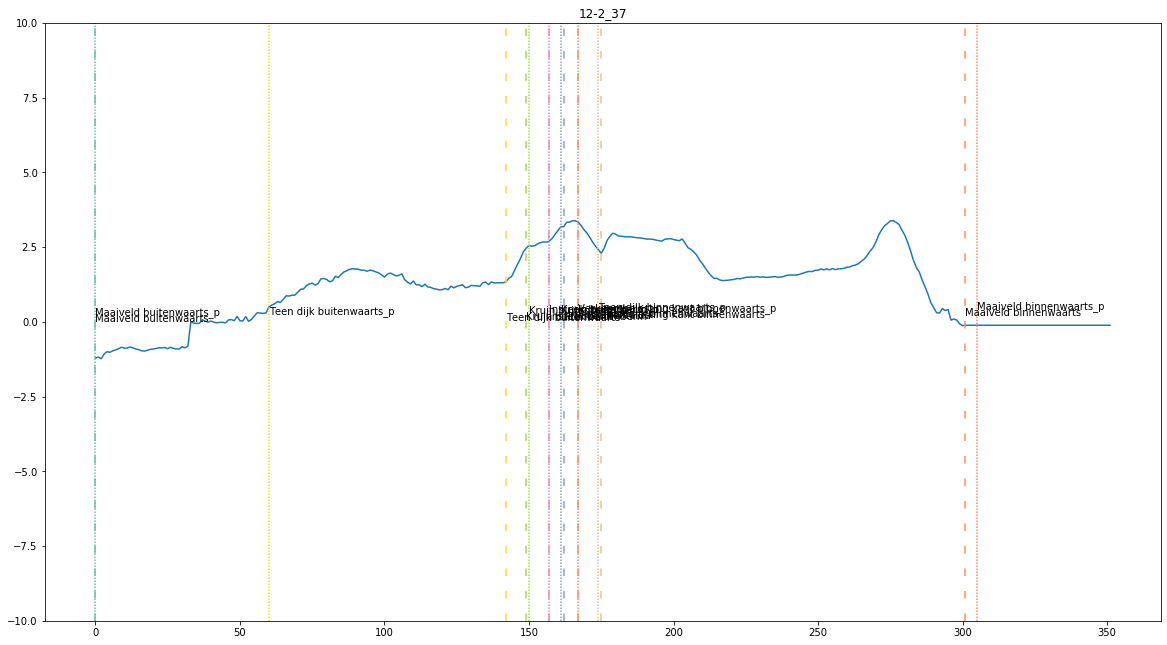

In [27]:
# inference_profile_dict = profile_dict
inference_profile_dict = profile_dict_test

model.eval()
cmap = sns.color_palette("Set2",len(set(class_dict.values())))

key = np.random.choice(list(inference_profile_dict.keys()))
random_sample_x = inference_profile_dict[key]['profile']
random_sample_y = inference_profile_dict[key]['label']

fig, ax = plt.subplots(figsize=(20,11))
plt.title(key)
sns.lineplot(data=scaler.inverse_transform(random_sample_x.reshape(-1,1)).reshape(-1))
ax.set_ylim(top=10, bottom=-10)
label_height = 0
label_height_distance = np.max(random_sample_x)/21

shp = random_sample_x.shape
fake_batch = torch.tensor(random_sample_x.reshape(1, 1, shp[0])).to(device)

outputs = model(fake_batch)
flat_output = torch.argmax(outputs, dim=1).cpu()
pred = flat_output[0].numpy()

prev_class_n = 999
for index, class_n in enumerate(random_sample_y):
    if class_n == 0:
        continue
    if class_n != prev_class_n:
        plt.axvline(index, 0,5, color=cmap[class_n], linestyle=(0,(5,10))) # loose dashes
        plt.text(index, label_height, inverse_class_dict[class_n], rotation=0)
        label_height += label_height_distance
        prev_class_n = class_n

used_classes = []
prev_class_n = 999
for index, class_n in enumerate(pred):
    if class_n == 0 or class_n in used_classes:
        continue
    if class_n != prev_class_n:
        plt.axvline(index, 0,5, color=cmap[class_n], linestyle=(0,(1,1))) # small dots
        plt.text(index, label_height, inverse_class_dict[class_n] + "_p", rotation=0)
        label_height += label_height_distance
        used_classes.append(prev_class_n)
        prev_class_n = class_n

## Generate annotations for all all the profiles and save to csv
Run this block to make all predictions and save the results to a characteristicpoints csv file

In [22]:
# final code
inference_profile_dict = profile_dict_test
inference_surfacelines = surfaceline_dict_test
output_csv_basename = "data/charpoints_generated_12-2"

model.eval()

accumulator = np.zeros((len(inference_profile_dict), 352))
for i, key in enumerate(inference_profile_dict.keys()):
    accumulator[i] = inference_profile_dict[key]['profile'][:352]
    
print("total profiles to predict: ", accumulator.shape[0])
accumulator = accumulator.reshape(822,1,352)

outputs = model(torch.tensor(accumulator).to(device).float())
flat_output = torch.argmax(outputs, dim=1).cpu()
predictions = flat_output.numpy()



header = ["LOCATIONID", "X_Maaiveld binnenwaarts", "Y_Maaiveld binnenwaarts", "Z_Maaiveld binnenwaarts", "X_Insteek sloot polderzijde", "Y_Insteek sloot polderzijde", "Z_Insteek sloot polderzijde", "X_Slootbodem polderzijde", "Y_Slootbodem polderzijde", "Z_Slootbodem polderzijde", "X_Slootbodem dijkzijde", "Y_Slootbodem dijkzijde", "Z_Slootbodem dijkzijde", "X_Insteek sloot dijkzijde", "Y_Insteek sloot dijkzijde", "Z_Insteek sloot dijkzijde", "X_Teen dijk binnenwaarts", "Y_Teen dijk binnenwaarts", "Z_Teen dijk binnenwaarts", "X_Kruin binnenberm", "Y_Kruin binnenberm", "Z_Kruin binnenberm", "X_Insteek binnenberm", "Y_Insteek binnenberm", "Z_Insteek binnenberm", "X_Kruin binnentalud", "Y_Kruin binnentalud", "Z_Kruin binnentalud", "X_Verkeersbelasting kant binnenwaarts", "Y_Verkeersbelasting kant binnenwaarts", "Z_Verkeersbelasting kant binnenwaarts", "X_Verkeersbelasting kant buitenwaarts", "Y_Verkeersbelasting kant buitenwaarts", "Z_Verkeersbelasting kant buitenwaarts", "X_Kruin buitentalud", "Y_Kruin buitentalud", "Z_Kruin buitentalud", "X_Insteek buitenberm", "Y_Insteek buitenberm", "Z_Insteek buitenberm", "X_Kruin buitenberm", "Y_Kruin buitenberm", "Z_Kruin buitenberm", "X_Teen dijk buitenwaarts", "Y_Teen dijk buitenwaarts", "Z_Teen dijk buitenwaarts", "X_Insteek geul", "Y_Insteek geul", "Z_Insteek geul", "X_Teen geul", "Y_Teen geul", "Z_Teen geul", "X_Maaiveld buitenwaarts", "Y_Maaiveld buitenwaarts", "Z_Maaiveld buitenwaarts"]
ordered_point_names = ['Maaiveld binnenwaarts'
                        'Insteek sloot polderzijde',
                        'Slootbodem polderzijde',
                        'Slootbodem dijkzijde',
                        'Insteek sloot dijkzijde',
                        'Teen dijk binnenwaarts',
                        'Kruin binnenberm',
                        'Insteek binnenberm',
                        'Kruin binnentalud',
                        'Verkeersbelasting kant binnenwaarts',
                        'Verkeersbelasting kant buitenwaarts', 
                        'Kruin buitentalud',
                        'Insteek buitenberm',
                        'Kruin buitenberm',
                        'Teen dijk buitenwaarts',
                        'Insteek geul',
                        'Teen geul',
                        'Maaiveld buitenwaarts'
                      ]

# WORKING ON STUFF HERE
# construct entries
with open('{}.csv'.format(output_csv_basename), 'w') as csvFile:
    writer = csv.writer(csvFile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(header)
    for i, key in enumerate(inference_profile_dict.keys()):
        # get predictions
        profile_pred = predictions[i]
        
        # construct dict with key for each row
        row_dict = {key:-1 for key in header}
        row_dict["LOCATIONID"] = key
        
        # loop through predictions and for the entries
        used_classes = []
        prev_class_n = 999 # key thats not in the inverse_class_dict
        for index, class_n in enumerate(profile_pred):
            if class_n == 0 or class_n in used_classes:
                continue
            if class_n != prev_class_n:
                # get class name
                class_name = inverse_class_dict[class_n]
                
                # if this index is different from the last, this is the characteristicpoint
                used_classes.append(prev_class_n)
                
                # set prev_class to the new class
                prev_class_n = class_n
                         
                # construct the csv row with the new class
                if index >= len(inference_surfacelines[key]):
                    continue
                
                (x,y,z) = inference_surfacelines[key][index]
                row_dict["X_" + class_name] = round(x, 3)
                row_dict["Y_" + class_name] = round(y, 3)
                row_dict["Z_" + class_name] = round(z, 3)

        # write the row to the csv file
        row = []
        for columnname in header:
            row.append(row_dict[columnname])
        writer.writerow(row)
    
csvFile.close()
print("done!")

total profiles to predict:  822
done!
